In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-5v15nek6
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-5v15nek6
  Resolved https://github.com/jlopezalo/pyafmreader.git to commit 68b3a64249d775dabc52e3a611fefecabbdb72c5
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-2rcyu7za/fasterzip_324170363e9d4e3d96b96e3c33d50b0c
  Running command git clone --filter=blob:none --quiet https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-2rcyu7

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-sddcbgqe
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-sddcbgqe
  Resolved https://github.com/jlopezalo/pyafmrheo.git to commit f89842094bce872e7560b3bf71ab7833b230881d
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pyafmrheo, since package 'wheel' is not installed.
  Running setup.py install for pyafmrheo ... done

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.routines.HertzFit import doHertzFit

In [203]:
# Define global variables
file_path = '/Users/javierlopez/Desktop/20221029/MIcrorheo/map-data-2022.10.29-14.39.03.268.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
tip_parameter = 5000 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# Window to find cp
windowforCP = 20e-9
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [204]:
file = loadfile(file_path)

In [205]:
filemetadata = file.filemetadata
print(filemetadata['file_type'])

.jpk-force-map


In [206]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [232]:
param_dict = {
    'def_sens': deflection_sensitivity,
    'k': spring_constant,
    'height_channel': height_channel,
    'poc_win': windowforCP,
    'curve_seg': 'extend',
    'fit_range_type': 'indentation',
    'min_ind': -np.inf,
    'max_ind': np.inf,
    'fit_line': False,
    'slope': 0,
    'd0': 0.0,
    'f0': 0.0,
    'auto_init_E0': True,
    'correct_tilt': True,
    'tilt_max_offset': 3e-6,
    'tilt_min_offset': 2e-6,
    'contact_model': indenter_shape,
    'tip_param': tip_parameter
}

In [233]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
force_curve.preprocess_force_curve(param_dict['def_sens'], param_dict['height_channel'])
if filemetadata['file_type'] in ('.jpk-force', '.jpk-force-map', '.jpk-qi-data'):
    force_curve.shift_height()

In [234]:
hertz_result = doHertzFit(force_curve, param_dict)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyafmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


In [235]:
hertz_result.fit_report()


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 5e-06

        BEC Model: None

        Number of free parameters: 3

        delta0: -1.6783791960842072e-07

        E0: 275.2446666396745

        f0: 1.0706687046011469e-11

        slope: None

        # Fit metrics
        MAE: 2.679983086376248e-20

        MSE: 2.1865470521699173e-22

        RMSE: 1.4786977555166292e-11

        Rsq: 0.9944852600429873

        Chisq: 2.2358577456879293e-09

        RedChisq: 7.452859152293098e-10

        


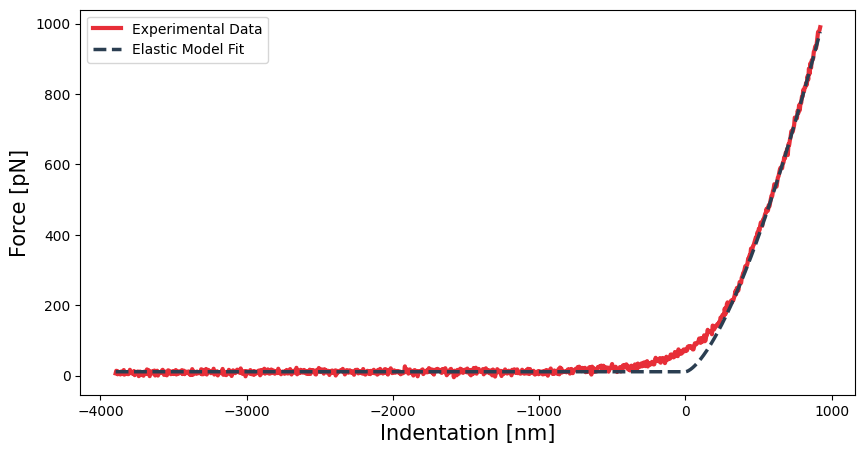

In [254]:
app = force_curve.get_segments()[0][1]
plt.plot(
    (app.indentation - hertz_result.delta0) * 1e6,
    (app.force + hertz_result.f0) * 1e12,
    color='#E72E38',
    linewidth=3,
    label='Experimental Data'
)
plt.plot(
    (app.indentation - hertz_result.delta0) * 1e9,
    hertz_result.eval(app.indentation) * 1e12,
    color='#2B3E51',
    linewidth=2.5,
    linestyle='--',
    label='Elastic Model Fit'
)
plt.xlabel('Indentation [nm]', fontsize = 15)
plt.ylabel('Force [pN]', fontsize = 15)
plt.legend()
plt.show()